# Updating the model for new data

By now we have about twice as many posts as before (~14,000 compared to ~7,000).
Time to retrain the model!

# Data import and cleaning

This procedure will be exactly the same as before.

In [1]:
import numpy as np
import pandas as pd

df = pd.read_parquet('posts.parquet')
print(f'Loaded {len(df)} posts')
df.head()

# Columns in this dataframe:
# 
#     id:        Reddit post ID on reddit. The post itself can be viewed at
#                https://reddit.com/r/pokemontrades/comments/{id}
#     title:     Post title.
#     body:      Post body (in Markdown format).
#     submitter: The username of the submitter
#     time:      Post submission time, in UTC
#     flair:     Post flair (at the time the post was scraped)
#     hit:       Whether ApriBot's crude detection mechanism (keyword-search) thought the post was Aprimon-related.
#     vote:      /r/BankBallExchange's judgment as to whether the post was Aprimon-related. This is the ground truth.

Loaded 14039 posts


,id,title,body,submitter,time,flair,hit,vote
0,13gxmuw,LF: Drilbur and Solosis FT: Ask,Hello! Im currently in the process of breeding...,Dracon715,2023-05-14 00:35:25,SMUSUM,True,False
1,13gx0eg,"LF: 6IV Non-English Ditto FT: Apriballs, Abili...",I’ve got pretty much everything aside from ✨ m...,MistaKleen,2023-05-14 00:07:42,SV,True,False
2,13gwnha,"LF H-Zoroark and Flabebe Codes, Jiseok Lee Gar...",Also open to other event offers!\n\n\_\_\_\_\_...,ShaikhAndBake,2023-05-13 23:51:47,Event,True,False
3,13gw0vt,"LF: Apriball Stonjourner, Yamask, Honedge, HA ...","Hi! I'm looking for a Stonjourner, Yamask, Hon...",Rainy_Days1115,2023-05-13 23:24:22,SWSH,True,True
4,13gw04b,LF: Sobble. FT: scarlet exclusives/raid exclusive,"It's the only raid exclusive that I'm missing,...",gertygaming,2023-05-13 23:23:23,SV (Closed),True,False


In [2]:
import re
import unidecode

def cleanup(text):
    # convert to ASCII
    text = unidecode.unidecode(text, errors='ignore')
    # remove Markdown links
    text = re.sub(r'\[([^\]]+)\]\([^)]+\)', r'\1', text)
    # split on spaces
    words = text.split()
    # remove links (heuristically)
    words = [w for w in words if not w.startswith('http') and not w.startswith('www')]
    # convert curly double/single quotes to plain single quotes
    words = [w.replace('“', "'").replace('”', "'").replace('‘', "'").replace('’', "'") for w in words]
    # split on other punctuation (except apostrophes and hyphens) and convert to lowercase
    words = [w for word in words for w in re.split(r"[^A-Za-z0-9'-]+", word.lower())]
    # remove any remaining punctuation
    words = [re.sub(r"[^A-Za-z0-9]", '', w) for w in words]
    # get rid of anything that doesn't have at least one letter
    words = [s for s in words if any(c.isalpha() for c in s)]
    # string back together
    return ' '.join(words)

df_processed = (df.assign(title=df.title.apply(cleanup))
                  .assign(body=df.body.apply(cleanup))
                  .assign(post=lambda df: df.title + ' ' + df.body)
                  .loc[:, ['id', 'title', 'body', 'post', 'vote']])
df_processed.head()

,id,title,body,post,vote
0,13gxmuw,lf drilbur and solosis ft ask,hello im currently in the process of breeding ...,lf drilbur and solosis ft ask hello im current...,False
1,13gx0eg,lf 6iv nonenglish ditto ft apriballs ability p...,ive got pretty much everything aside from mons...,lf 6iv nonenglish ditto ft apriballs ability p...,False
2,13gwnha,lf hzoroark and flabebe codes jiseok lee garga...,also open to other event offers gen shinies ge...,lf hzoroark and flabebe codes jiseok lee garga...,False
3,13gw0vt,lf apriball stonjourner yamask honedge ha dura...,hi im looking for a stonjourner yamask honedge...,lf apriball stonjourner yamask honedge ha dura...,True
4,13gw04b,lf sobble ft scarlet exclusives raid exclusive,its the only raid exclusive that im missing so...,lf sobble ft scarlet exclusives raid exclusive...,False


In [3]:
y_true = df_processed.vote.to_numpy().astype(int)
y_true

array([0, 0, 0, ..., 0, 0, 0])

# Train/test split

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_processed, y_true, test_size=0.2, random_state=468)

# Check that the train/test split is balanced.
print(f"1's in test set     : {np.count_nonzero(y_test)} out of {len(y_test)} ({np.count_nonzero(y_test) / len(y_test):.2%})")
print(f"1's in training set : {np.count_nonzero(y_train)} out of {len(y_train)} ({np.count_nonzero(y_train) / len(y_train):.2%})")

1's in test set     : 575 out of 2808 (20.48%)
1's in training set : 2200 out of 11231 (19.59%)


# Model

In [5]:
# General setup

from sklearn.model_selection import cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def cv(pipeline, k=5, plot=False):
    cv = cross_validate(pipeline, X_train, y_train, cv=k, scoring='f1',
                        return_estimator=plot, return_indices=plot)
    if plot: 
        # Get predictions from the estimator that was returned. This is slightly
        # inefficient, but still better than calling cross_val_score and then
        # cross_val_predict, which does the CV twice for no reason.
        y_pred = np.array([])
        y_true = np.array([])
        indices = np.array([])
        for i in range(k):
            estimator = cv['estimator'][i]
            test_indices = cv['indices']['test'][i]
            this_y_pred = estimator.predict(X_train.iloc[test_indices])
            this_y_train = y_train[test_indices]
            indices = np.concatenate((indices, test_indices))
            y_pred = np.concatenate((y_pred, this_y_pred))
            y_true = np.concatenate((y_true, this_y_train))
        # Plot confusion matrix
        _, ax = plt.subplots(figsize=(5, 5))
        ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(ax=ax)
        ax.set_title(f'CV F1 : {np.mean(cv["test_score"]):.4%}')
    # Return CV results
    return cv

# Individual models (using the parameters we had earlier)

## XGBoost

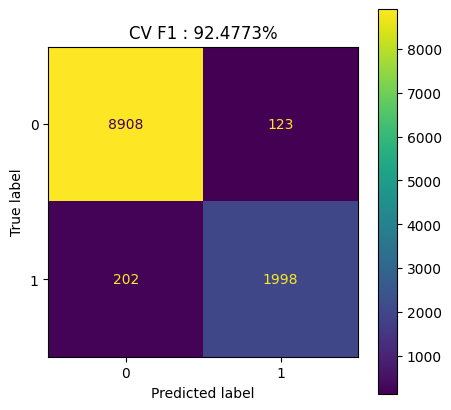

In [6]:
# CV score with smaller dataset: 92.6232%

import xgboost as xgb
xg = Pipeline([
    ('vec', ColumnTransformer([("post", CountVectorizer(ngram_range=(1, 2), max_features=5000), "post")])),
    ('clf', xgb.XGBClassifier(max_depth=7, n_estimators=200, objective='binary:logistic', )),
])

cv_xg = cv(xg, plot=True)

In [7]:
# Grid search CV for the best XGBoost parameters

from sklearn.model_selection import GridSearchCV

xg_grid = GridSearchCV(estimator=xg,
                       param_grid={
                            'clf__max_depth': [3, 5, 7, 9],
                            'clf__n_estimators': [100, 200, 400],
                       },
                       scoring='f1')
xg_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vec',
                                        ColumnTransformer(transformers=[('post',
                                                                         CountVectorizer(max_features=5000,
                                                                                         ngram_range=(1,
                                                                                                      2)),
                                                                         'post')])),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None...
                                                      learning_rate=None,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=7,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=200,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'clf__max_depth': [3, 5, 7, 9],
                         'clf__n_estimators': [100, 200, 400]},
             scoring='f1')

In [8]:
xg_grid.best_params_

{'clf__max_depth': 7, 'clf__n_estimators': 200}

## Logistic regression

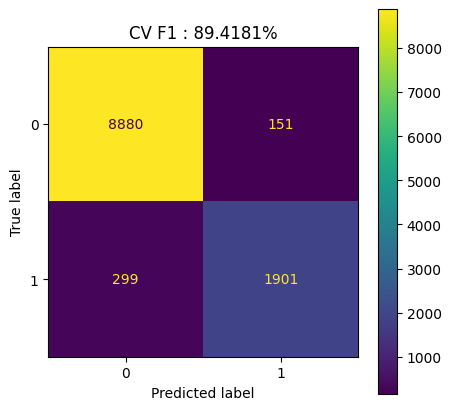

In [9]:
from sklearn.linear_model import LogisticRegression

lr = Pipeline([
    ('vec', ColumnTransformer([("post", CountVectorizer(ngram_range=(1, 2), max_features=5000), "post")])),
    ('clf', LogisticRegression(max_iter=5000)),
])

cv_lr = cv(lr, plot=True)

## Let's try to stack XGBoost and LR

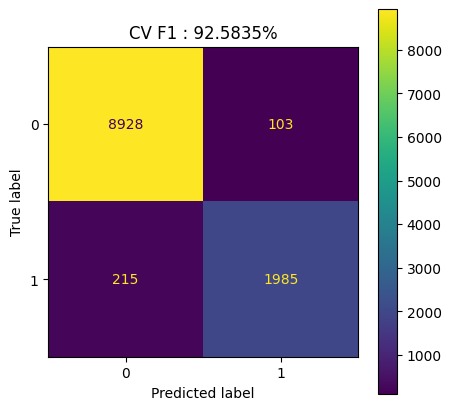

In [10]:
from sklearn.ensemble import StackingClassifier

stacked_xg_lr = StackingClassifier(
    estimators=[
        ('xg', xg),
        ('lr', lr),
    ],
    final_estimator=LogisticRegression(max_iter=5000)
)

cv_stacked = cv(stacked_xg_lr, plot=True)

And... let's run CV on the stacked model for good measure, overnight.

In [ ]:
stacked_grid = GridSearchCV(estimator=stacked_xg_lr,
                            param_grid={
                                'xg__clf__max_depth': [3, 5, 7, 9],
                                'xg__clf__n_estimators': [100, 200, 400],
                                'xg__vec__post__max_features': [2500, 5000, 10000],
                                'lr__vec__post__max_features': [2500, 5000, 10000],
                            },
                            scoring='f1')
stacked_grid.fit(X_train, y_train)

In [ ]:
stacked_grid.best_params_

In [ ]:
# Best estimator CV score with smaller dataset: 93.3095%

_ = cv(stacked_grid.best_estimator_, plot=True)

In [ ]:
# On test set
# Test score with previous smaller dataset: 93.3873%

optimised_model = stacked_grid.best_estimator_

optimised_model.fit(X_train, y_train)
y_pred = optimised_model.predict(X_test)

_, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay(confusion_matrix(y_true=y_test, y_pred=y_pred)).plot(ax=ax)
ax.set_title(f'Test F1 : {f1_score(y_true=y_test, y_pred=y_pred):.4%}')
plt.show()

# Save the model to disk

In [ ]:
import joblib

joblib.dump(optimised_model, 'stacked_xg_lr_model.joblib')